In [8]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:

file = '../data/processed/British Columbia_combined.csv'
series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
series = series.iloc[-30:]

<AxesSubplot:xlabel='Date'>

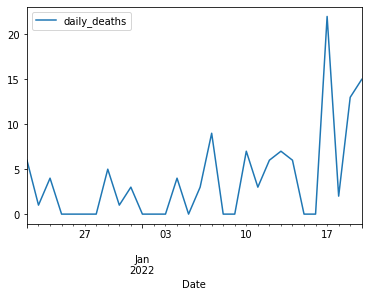

In [22]:
series.plot()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0) TrainRMSE=2.550566, TestRMSE=8.654548
1) TrainRMSE=2.496975, TestRMSE=8.444867
2) TrainRMSE=3.277439, TestRMSE=9.046120
3) TrainRMSE=2.454002, TestRMSE=8.317083
4) TrainRMSE=2.493693, TestRMSE=8.352692
5) TrainRMSE=2.470692, TestRMSE=8.571670
6) TrainRMSE=2.978632, TestRMSE=8.760743
7) TrainRMSE=3.153999, TestRMSE=8.842809
8) TrainRMSE=2.480176, TestRMSE=8.506679
9) TrainRMSE=2.567019, TestRMSE=8.698895


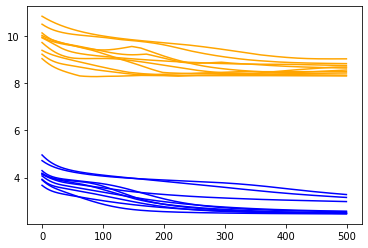

In [29]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		model.reset_states()
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
		model.reset_states()
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# run diagnostic experiments
def run():
    # load dataset
    series = read_csv(file, index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
    series = series.iloc[-36:]
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 500
    n_neurons = 1
    # run diagnostic tests
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('epochs_diagnostic.png')
 
# entry point
run()

In [28]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

raw_values = series.values
len(raw_values)

36

In [9]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

            daily_deaths
Date                    
2020-01-22           0.0
2020-01-23           0.0
2020-01-24           0.0
2020-01-25           0.0
2020-01-26           0.0


In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [2]:
bc_deaths = pd.read_csv('../data/processed/British Columbia_combined.csv', index_col='Date', parse_dates=['Date'], usecols=['Date', 'daily_deaths'])
bc_deaths

,daily_deaths
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2022-01-16,0.0
2022-01-17,22.0
2022-01-18,2.0


In [3]:
dataset = bc_deaths.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

694

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


In [5]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01351351, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04054054,
       0.        , 0.04054054, 0.        , 0.01351351, 0.02702703])]
[0.0]

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.      